In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
os.chdir('/content/drive/MyDrive')
data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


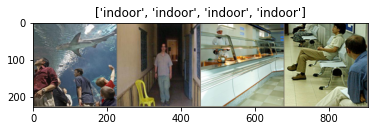

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet

In [10]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to  len(class_names)
model_ft.classifier[1] = torch.nn.Linear(in_features=model_ft.classifier[1].in_features, out_features=2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5070 Acc: 0.7862
val Loss: 0.1947 Acc: 0.9333

Epoch 1/24
----------
train Loss: 0.5018 Acc: 0.8323
val Loss: 0.7079 Acc: 0.7467

Epoch 2/24
----------
train Loss: 0.4021 Acc: 0.8615
val Loss: 0.3823 Acc: 0.8400

Epoch 3/24
----------
train Loss: 0.4358 Acc: 0.8354
val Loss: 0.2362 Acc: 0.9133

Epoch 4/24
----------
train Loss: 0.3594 Acc: 0.8831
val Loss: 0.2115 Acc: 0.9200

Epoch 5/24
----------
train Loss: 0.4205 Acc: 0.8662
val Loss: 0.1601 Acc: 0.9200

Epoch 6/24
----------
train Loss: 0.3588 Acc: 0.8785
val Loss: 0.2308 Acc: 0.9267

Epoch 7/24
----------
train Loss: 0.2340 Acc: 0.9015
val Loss: 0.2765 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.2357 Acc: 0.9046
val Loss: 0.2125 Acc: 0.9267

Epoch 9/24
----------
train Loss: 0.2140 Acc: 0.9246
val Loss: 0.1681 Acc: 0.9267

Epoch 10/24
----------
train Loss: 0.2476 Acc: 0.8846
val Loss: 0.1742 Acc: 0.9200

Epoch 11/24
----------
train Loss: 0.2544 Acc: 0.9046
val Loss: 0.1640 Acc: 0.9133

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


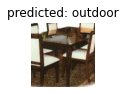

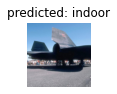

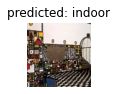

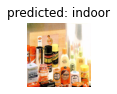

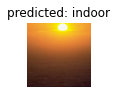

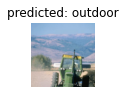

In [11]:
visualize_model(model_ft)

ConvNet as fixed feature extractor


In [15]:
model_conv = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[1] = torch.nn.Linear(in_features=model_conv.classifier[1].in_features, out_features=2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3954 Acc: 0.8092
val Loss: 0.1378 Acc: 0.9467

Epoch 1/24
----------
train Loss: 0.4237 Acc: 0.8308
val Loss: 0.1995 Acc: 0.9200

Epoch 2/24
----------
train Loss: 0.4185 Acc: 0.8308
val Loss: 0.2019 Acc: 0.9333

Epoch 3/24
----------
train Loss: 0.4212 Acc: 0.8338
val Loss: 0.2264 Acc: 0.9133

Epoch 4/24
----------
train Loss: 0.4629 Acc: 0.8077
val Loss: 0.4149 Acc: 0.8467

Epoch 5/24
----------
train Loss: 0.3452 Acc: 0.8477
val Loss: 0.3466 Acc: 0.8867

Epoch 6/24
----------
train Loss: 0.5543 Acc: 0.8231
val Loss: 0.3772 Acc: 0.8800

Epoch 7/24
----------
train Loss: 0.3167 Acc: 0.8831
val Loss: 0.3034 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.3206 Acc: 0.8708
val Loss: 0.2480 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.2820 Acc: 0.8862
val Loss: 0.4426 Acc: 0.8667

Epoch 10/24
----------
train Loss: 0.2677 Acc: 0.8877
val Loss: 0.3222 Acc: 0.8800

Epoch 11/24
----------
train Loss: 0.3289 Acc: 0.8785
val Loss: 0.3299 Acc: 0.8867

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


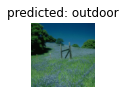

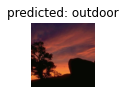

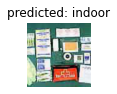

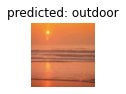

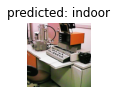

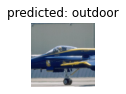

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()